### Practice 1: Parallel GloVe

In this assignment we'll build parallel GloVe training from scratch. Well, almost from scratch:
* we'll use python's builtin [`multiprocessing`](https://docs.python.org/3/library/multiprocessing.html) library
* and learn to access numpy arrays from multiple processes!

![img](https://i.imgur.com/YHluIBo.png)

In [1]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1
# set numpy to single-threaded mode for benchmarking

!pip install --upgrade nltk datasets tqdm
!wget https://raw.githubusercontent.com/yandexdataschool/dlatscale_draft/main/week01/utils.py -O utils.py

import time, random
import multiprocessing as mp
import numpy as np
from tqdm import tqdm, trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1
--2021-02-19 00:41:39--  https://raw.githubusercontent.com/yandexdataschool/dlatscale_draft/main/week01/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1071 (1,0K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1,05K  --.-KB/s    in 0s      

2021-02-19 00:41:39 (113 MB/s) - ‘utils.py’ saved [1071/1071]



### Multiprocessing basics

In [2]:
def foo(i):
    """ Imagine particularly computation-heavy function... """
    print(end=f"Began foo({i})...\n")
    result = np.sin(i)
    time.sleep(abs(result))
    print(end=f"Finished foo({i}) = {result:.3f}.\n")
    return result

In [3]:
%%time
results_naive = [foo(i) for i in range(10)]

Began foo(0)...
Finished foo(0) = 0.000.
Began foo(1)...
Finished foo(1) = 0.841.
Began foo(2)...
Finished foo(2) = 0.909.
Began foo(3)...
Finished foo(3) = 0.141.
Began foo(4)...
Finished foo(4) = -0.757.
Began foo(5)...
Finished foo(5) = -0.959.
Began foo(6)...
Finished foo(6) = -0.279.
Began foo(7)...
Finished foo(7) = 0.657.
Began foo(8)...
Finished foo(8) = 0.989.
Began foo(9)...
Finished foo(9) = 0.412.
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.95 s


Same, but with multiple processes

In [4]:
%%time
processes = []
for i in range(10):
    proc = mp.Process(target=foo, args=[i])
    processes.append(proc)

print(f"Created {len(processes)} processes!")

# start in parallel
for proc in processes:
    proc.start()
    
# wait for everyone finish
for proc in processes:
    proc.join()  # wait until proc terminates

Created 10 processes!
Began foo(0)...
Began foo(1)...
Finished foo(0) = 0.000.
Began foo(2)...
Began foo(3)...
Began foo(4)...
Began foo(5)...
Began foo(6)...
Began foo(7)...
Began foo(8)...
Began foo(9)...
Finished foo(3) = 0.141.
Finished foo(6) = -0.279.
Finished foo(9) = 0.412.
Finished foo(7) = 0.657.
Finished foo(4) = -0.757.
Finished foo(1) = 0.841.
Finished foo(2) = 0.909.
Finished foo(5) = -0.959.
Finished foo(8) = 0.989.
CPU times: user 4 ms, sys: 32 ms, total: 36 ms
Wall time: 1.02 s


```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

Great! But how do we collect the values?

__Solution 1:__ with pipes!

Two "sides", __one__ process from each side
* `pipe_side.send(data)` - throw data into the pipe (do not wait for it to be read)
* `data = pipe_side.recv()` - read data. If there is none, wait for someone to send data

__Rules:__
* each side should be controlled by __one__ process
* data transferred through pipes must be serializable
* if `duplex=True`, processes can communicate both ways
* if `duplex=False`, "left" receives and "right" side sends

In [5]:
side_A, side_B = mp.Pipe()

side_A.send(123)
side_A.send({'ololo': np.random.randn(3)})

print("side_B.recv() -> ", side_B.recv())
print("side_B.recv() -> ", side_B.recv())

# note: calling recv a third will hang the process (waiting for someone to send data)

side_B.recv() ->  123
side_B.recv() ->  {'ololo': array([-0.67339228,  0.74757677, -0.46377178])}


In [6]:
def compute_and_send(i, output_pipe):
    print(end=f"Began compute_and_send({i})...\n")
    result = np.sin(i)
    time.sleep(abs(result))
    print(end=f"Finished compute_and_send({i}) = {result:.3f}.\n")
    
    output_pipe.send(result)

In [7]:
%%time
result_pipes = []

for i in range(10):
    
    side_A, side_B = mp.Pipe(duplex=False)
    # note: duplex=False means that side_B can only send
    # and side_A can only recv. Otherwise its bidirectional
    result_pipes.append(side_A)
    proc = mp.Process(target=compute_and_send, args=[i, side_B])
    proc.start()

print("MAIN PROCESS: awaiting results...")
for pipe in result_pipes:
    print(f"MAIN_PROCESS: received {pipe.recv()}")
print("MAIN PROCESS: done!")

Began compute_and_send(0)...
Finished compute_and_send(0) = 0.000.
Began compute_and_send(1)...
Began compute_and_send(2)...
Began compute_and_send(3)...
Began compute_and_send(4)...
Began compute_and_send(5)...
Began compute_and_send(6)...
Began compute_and_send(7)...
Began compute_and_send(8)...
Began compute_and_send(9)...
Finished compute_and_send(3) = 0.141.
MAIN PROCESS: awaiting results...
MAIN_PROCESS: received 0.0
Finished compute_and_send(6) = -0.279.
Finished compute_and_send(9) = 0.412.
Finished compute_and_send(7) = 0.657.
Finished compute_and_send(4) = -0.757.
Finished compute_and_send(1) = 0.841.
Finished compute_and_send(2) = 0.909.
Finished compute_and_send(5) = -0.959.
Finished compute_and_send(8) = 0.989.
MAIN_PROCESS: received 0.8414709848078965
MAIN_PROCESS: received 0.9092974268256817
MAIN_PROCESS: received 0.1411200080598672
MAIN_PROCESS: received -0.7568024953079282
MAIN_PROCESS: received -0.9589242746631385
MAIN_PROCESS: received -0.27941549819892586
MAIN_PROCE

__Solution 2:__ with multiprocessing templates

Multiprocessing contains some template data structures that help you communicate between processes.

One such structure is `mp.Queue` a Queue that can be accessed by multiple processes in parallel.
* `queue.put` adds the value to the queue, accessible by all other processes
* `queue.get` returns the earliest added value and removes it from queue

In [8]:
queue = mp.Queue()

def func_A(queue):
    print("A: awaiting queue...")
    print("A: retreived from queue:", queue.get())
    print("A: awaiting queue...")
    print("A: retreived from queue:", queue.get())
    print("A: done!")

def func_B(i, queue):
    value = np.random.rand()
    time.sleep(value)
    print(f"proc_B{i}: putting more stuff into queue!")
    queue.put(value)
    

proc_A = mp.Process(target=func_A, args=[queue])
proc_A.start();

proc_B1 = mp.Process(target=func_B, args=[1, queue])
proc_B2 = mp.Process(target=func_B, args=[2, queue])
proc_B1.start(), proc_B2.start();

A: awaiting queue...
proc_B1: putting more stuff into queue!
A: retreived from queue: 0.2950978161891834
A: awaiting queue...
proc_B2: putting more stuff into queue!
A: retreived from queue: 0.2950978161891834
A: done!


__Important note:__ you can see that the two values above are identical.

This is because proc_B1 and proc_B2 were forked (cloned) with __the same random state!__

To mitigate this issue, run `np.random.seed()` in each process (same for torch, tensorflow).

<details>
    <summary>In fact, please go and to that <b>right now!</b></summary>
    <img src='https://media.tenor.com/images/32c950f36a61ec7e5060f5eee9140396/tenor.gif' height=200px>
</details>

```

```

__Less important note:__ `mp.Queue vs mp.Pipe`
- pipes are much faster for 1v1 communication
- queues support arbitrary number of processes
- queues are implemented with pipes

### GloVe preprocessing

Before we can train GloVe, we must first construct the co-occurence

In [9]:
import datasets
data = datasets.load_dataset('wikitext', 'wikitext-103-raw-v1')
# for fast debugging, you can temporarily use smaller data: 'wikitext-2-raw-v1'

print("Example:", data['train']['text'][5])

Reusing dataset wikitext (/home/jheuristic/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/47c57a6745aa5ce8e16a5355aaa4039e3aa90d1adad87cef1ad4e0f29e74ac91)


Example:  It met with positive sales in Japan , and was praised by both Japanese and western critics . After release , it received downloadable content , along with an expanded edition in November of that year . It was also adapted into manga and an original video animation series . Due to low sales of Valkyria Chronicles II , Valkyria Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 . Media.Vision would return to the franchise with the development of Valkyria : Azure Revolution for the PlayStation 4 . 



__First,__ let's build a vocabulary:

In [10]:
from collections import Counter
from nltk.tokenize import NLTKWordTokenizer
tokenizer = NLTKWordTokenizer()

def count_tokens(lines, top_k=None):
    """ Tokenize lines and return top_k most frequent tokens and their counts """
    sent_tokens = tokenizer.tokenize_sents(map(str.lower, lines))
    token_counts = Counter([token for sent in sent_tokens for token in sent])
    return Counter(dict(token_counts.most_common(top_k)))

count_tokens(data['train']['text'][:100], top_k=10)

Counter({'the': 459,
         ',': 349,
         '.': 225,
         'of': 193,
         'to': 150,
         'and': 147,
         'in': 104,
         '@': 100,
         'a': 93,
         'was': 83})

In [11]:
# sequential algorithm
texts = data['train']['text'][:100_000]
vocabulary_size = 32_000
batch_size = 10_000

token_counts = Counter()

for batch_start in trange(0, len(texts), batch_size):
    batch_texts = texts[batch_start: batch_start + batch_size]
    batch_counts = count_tokens(batch_texts, top_k=vocabulary_size)
    token_counts += Counter(batch_counts)
        
token_counts = Counter(dict(token_counts.most_common(vocabulary_size)))

# save for later
token_counts_reference = Counter(token_counts)

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


### Let's parallelize (0.2 score)

__Your task__ is to speed up the code above using using multiprocessing with queues and/or pipes _(or [shared memory](https://docs.python.org/3/library/multiprocessing.shared_memory.html) if you're up to that)_.

__Kudos__ for implementing some form of global progress tracker (like progressbar above)

Please do **not** use task executors (e.g. mp.pool, joblib, ProcessPoolExecutor), we'll get to them soon!

In [ ]:
texts = data['train']['text'][:100_000]
vocabulary_size = 32_000
batch_size = 10_000

<YOUR CODE HERE>

token_counts = <...>

In [ ]:
assert len(token_counts) == len(token_counts_reference)
for token, ref_count in token_counts_reference.items():
    assert token in token_counts, token
    assert token_counts[token] == ref_count, token

vocabulary = sorted(token_counts.keys())
token_to_index = {token: i for i, token in enumerate(vocabulary)}
assert len(vocabulary) == vocabulary_size, len(vocabulary)
print("Well done!")

### Part 2: Construct co-occurence matrix (0.1 score)


__Your task__ is to count co-occurences of all words in a 5-token window. Please use the same preprocessing and tokenizer as above.

__Also:__ please only count words that are in the vocabulary defined above.

![image.png](https://i.imgur.com/2XmhYn5.png)



__Note:__ this task and everything below has no instructions/interfaces. We will design those interfaces __together on the seminar.__

The detailed instructions will appear later this night after the seminar is over.
However, if you want to write the code from scratch, feel free to ignore these instructions.


In [ ]:
import scipy

def count_token_cooccurences(lines, vocabulary_size: int, window_size: int):
    """ Tokenize lines and return top_k most frequent tokens and their counts """
    cooc = Counter()

    for line in lines:
        tokens = tokenizer.tokenize(line.lower())
        token_ix = [token_to_index[token] for token in tokens
                    if token in token_to_index]
        
        for i in range(len(token_ix)):
            for j in range(max(i - window_size, 0),
                           min(i + window_size + 1, len(token_ix))):
                if i != j:
                    cooc[token_ix[i], token_ix[j]] += 1 / abs(i - j)
    return counter_to_matrix(cooc, vocabulary_size)

def counter_to_matrix(counter, vocabulary_size):
    keys, values = zip(*counter.items())
    ii, jj = zip(*keys)
    return scipy.sparse.csr_matrix((values, (ii, jj)), dtype='float32',
                                   shape=(vocabulary_size, vocabulary_size))

In [ ]:
texts = data['train']['text'][:100_000]
batch_size = 10_000
window_size = 5

cooc = scipy.sparse.csr_matrix((vocabulary_size, vocabulary_size), dtype='float32')
for batch_start in trange(0, len(texts), batch_size):
    batch_texts = texts[batch_start: batch_start + batch_size]
    batch_cooc = count_token_cooccurences(batch_texts, vocabulary_size, window_size)
    cooc += batch_cooc
    

# This cell will run for a couple minutes, go get some tea!
reference_cooc = cooc

__Simple parallelism with `mp.Pool`__

Many standard parallel tasks, such as applying the same function to an array of inputs, can be automated by using prebuilt primitives such as Pool.

In [ ]:
def foo(i):
    print(f'Began foo({i})', flush=True)
    time.sleep(1)
    print(f'Done foo({i})', flush=True)
    return i ** 2

with mp.Pool(processes=8) as pool:
    results = pool.map(foo, range(5))
    
# or use iterators:
# for result in pool.imap(foo, range(5)):
#    print('Got', result)

__Our next step__ is to implement a parallel version of co-occurence computation using the process pool functionality.

There are multiple alternatives to mp.Pool: [joblib.Parallel](https://joblib.readthedocs.io/en/latest/), [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.ProcessPoolExecutor), [ipyparallel](https://github.com/ipython/ipyparallel), etc. Feel free to use whichever one you prefer.

In [ ]:
texts = data['train']['text'][:100_000]
batch_size = 10_000
window_size = 5

<YOUR CODE HERE>

cooc = <...>

In [ ]:
assert isinstance(cooc, scipy.sparse.csr_matrix)
assert cooc.nnz == reference_cooc.nnz
for _ in trange(100_000):
    i, j = np.random.randint(0, vocabulary_size, size=2)
    assert np.allclose(cooc[i, j], reference_cooc[i, j])

print("Perfect!")

__Preprocess and save the full data__

Finally, let's run the preprocessing code for the entire dataset and save the results for training.

In [ ]:
texts = data['train']['text']
vocabulary_size = 32_000
batch_size = 10_000
window_size = 5

# YOUR CODE: compute both vocabulary and cooc on the entire training corpora and save the results

<A WHOLE LOT OF YOUR CODE>

token_counts = <...>
cooc = <...>

In [ ]:
assert len(vocabulary) == vocabulary_size
assert cooc.shape == (vocabulary_size, vocabulary_size)
assert 440_000_000 < np.sum(cooc) < 450_000_000
assert 0.05 < cooc.nnz / vocabulary_size ** 2 < 0.06

In [ ]:
import pickle
with open('preprocessed_data.pcl', 'wb') as f:
    pickle.dump((vocabulary, cooc.tocoo()), f)

### Finally, GloVe!  (0.2 score)

In [ ]:
import pickle
with open('preprocessed_data.pcl', 'rb') as f:
    vocabulary, cooc = pickle.load(f)

### Weight function
![image.png](https://i.imgur.com/Cdu6BJ5.png)

In [ ]:
def compute_loss_weights(counts_ij):
    """ Compute GloVe weights """
    <YOUR CODE HERE>
    return <...>

In [ ]:
dummy_weights = compute_loss_weights(np.arange(0, 200, 30))
dummy_reference_weights = [0. , 0.40536, 0.681731, 0.92402, 1. , 1. , 1.]
assert np.allclose(dummy_weights, dummy_reference_weights, rtol=1e-4, atol=1e-3)

### Loss function

![img](https://i.imgur.com/I8nDIV1.png)


__The goal__ is to compute the loss function as per formula above. The only difference is that you should take _mean_ over batch instead of sum.

In [ ]:
def compute_loss(emb_ii, emb_jj, bias_ii, bias_jj, counts_ij):
    """
    Compute GloVe loss function given embeddings, biases and targets
    
    :param emb_ii, emb_jj: vectors of left- and right-side words, shape: [batch_size, embedding_dimension]
    :param bias_ii, bias_jj: biases for left- and right-side words, shape: [batch_size]
    :param counts_ij: values from co-occurence matrix, shape: [batch_size]
    :returns: mean GloVe loss over batch, shape: scalar
    """
    weights = compute_loss_weights(counts_ij)
    target = np.log(counts_ij)
    
    <YOUR CODE>
    
    return <...>


In [ ]:
dummy_emb_ii = np.sin(np.linspace(0, 10, 40)).reshape(4, 10)
dummy_emb_jj = np.cos(np.linspace(10, 20, 40)).reshape(4, 10)
dummy_bias_ii = np.linspace(-3, 2, 4)
dummy_bias_jj = np.linspace(4, -1, 4)
dummy_counts_ij = np.abs(np.sin(np.linspace(1, 100, 4)) * 150)

dummy_loss = compute_loss(dummy_emb_ii, dummy_emb_jj, dummy_bias_ii, dummy_bias_jj, dummy_counts_ij)

assert np.shape(dummy_loss) == ()
assert np.allclose(dummy_loss, 1.84289356)

In [ ]:
def compute_grads(emb_ii, emb_jj, bias_ii, bias_jj, counts_ij):
    """
    Compute gradients of GloVe loss with respect to emb_ii/jj and bias_ii/jj
    Assume the same parameter shapes as above
    :returns: (grad_wrt_emb_ii, grad_wrt_emb_jj, grad_wrt_bias_ii, grad_wrt_bias_jj)
    """
    <YOUR CODE>
    
    return <...>, <...>, <...>, <...>

In [ ]:
grad_emb_ii, grad_emb_jj, grad_bias_ii, grad_bias_jj = compute_grads(
    dummy_emb_ii, dummy_emb_jj, dummy_bias_ii, dummy_bias_jj, dummy_counts_ij)

assert np.shape(grad_emb_ii) == np.shape(grad_emb_jj) == np.shape(dummy_emb_ii)
assert np.shape(grad_bias_ii) == np.shape(grad_bias_jj) == np.shape(dummy_bias_ii)

In [ ]:
from utils import eval_numerical_gradient
reference_grad_bias_ii = eval_numerical_gradient(
    lambda x: compute_loss(dummy_emb_ii, dummy_emb_jj, x, dummy_bias_jj, dummy_counts_ij),
    x=dummy_bias_ii)

assert np.allclose(reference_grad_bias_ii, grad_bias_ii, rtol=1e-4, atol=1e-3)
print("dL/db[ii] OK")

reference_grad_bias_jj = eval_numerical_gradient(
    lambda x: compute_loss(dummy_emb_ii, dummy_emb_jj, dummy_bias_ii, x, dummy_counts_ij),
    x=dummy_bias_jj)

assert np.allclose(reference_grad_bias_jj, grad_bias_jj, rtol=1e-4, atol=1e-3)
print("dL/db[jj] OK")

In [ ]:
reference_grad_emb_ii = eval_numerical_gradient(
    lambda x: compute_loss(x, dummy_emb_jj, dummy_bias_ii, dummy_bias_jj, dummy_counts_ij),
    x=dummy_emb_ii)

assert np.allclose(reference_grad_emb_ii, grad_emb_ii, rtol=1e-4, atol=1e-3)
print("dL/dEmb[ii] OK")


reference_grad_emb_jj = eval_numerical_gradient(
    lambda x: compute_loss(dummy_emb_ii, x, dummy_bias_ii, dummy_bias_jj, dummy_counts_ij),
    x=dummy_emb_jj)

assert np.allclose(reference_grad_emb_jj, grad_emb_jj, rtol=1e-4, atol=1e-3)
print("dL/dEmb[ii] OK")

print("All tests passed!")

### Part 3: Parallel GloVe training (0.5 score)

Finally, let's write the actual parameter server for parallel GloVe training. In order to do so efficiently, we shall use shared memory instead of pipes.

You can find an example of how shared memory works below:


### Demo: shared memory

In [ ]:
def make_shared_array(shape, dtype, fill=None, lock=True):
    """ Create a numpy array that is shared across processes. """
    size = int(np.prod(shape))
    ctype = np.ctypeslib.as_ctypes_type(dtype)
    if lock:
        x_mp = mp.Array(ctype, size, lock=True).get_obj()
    else:
        x_mp = mp.Array(ctype, size, lock=False)
    array = np.ctypeslib.as_array(x_mp)
    if fill is not None:
        array[...] = fill
    return np.reshape(array, shape)

In [ ]:
shared_array = make_shared_array((5, 5), 'float32', fill=1)
normal_array = np.ones((5, 5), 'float32')

In [ ]:
def proc_A():
    time.sleep(0.5)
    print("A: setting value at [2, 3]")
    shared_array[2, 3] = 42
    normal_array[2, 3] = 42
    time.sleep(1)
    print(f"B: value after 1.5s: normal = {normal_array[2, 3]}\t shared = {shared_array[2, 3]}")
    
def proc_B():
    print(f"B: initial value: normal = {normal_array[2, 3]}\t shared = {shared_array[2, 3]}")
    time.sleep(1)
    print(f"B: value after 1s: normal = {normal_array[2, 3]}\t shared = {shared_array[2, 3]}")
    print("A: dividing value at [2, 3] by 2")
    shared_array[2, 3] /= 2
    normal_array[2, 3] /= 2

In [ ]:
mp.Process(target=proc_A).start()
mp.Process(target=proc_B).start()

In [ ]:
# the same can be done with individual values:
x = mp.Value(np.ctypeslib.as_ctypes_type(np.int32))
x.value += 1 # shared across all processes

__So, let's put all trainable parameters in shared memory!__

In [ ]:
class SharedEmbeddings:
    """
    Word embeddings trainable parameters, allocated in shared memory
    """
    def __init__(self, vocabulary_size: int, embedding_dimension: int, init_scale: float = 0.01):
        self.embeddings = make_shared_array([vocabulary_size, embedding_dimension], np.float32, lock=False)
        self.embeddings[...] = np.random.randn(*self.embeddings.shape) * init_scale
        
        self.biases = make_shared_array([vocabulary_size], np.float32, fill=0.0, lock=False)

### Training (single-core baseline)

In [ ]:
batch_size = 64
learning_rate = 0.01
max_steps = 10 ** 6

start_time = time.perf_counter()
timestep_history = []
loss_history = []

model = SharedEmbeddings(vocabulary_size, embedding_dimension=256)

In [ ]:
for t in trange(max_steps):
    batch_ix = np.random.randint(0, len(cooc.row), size=batch_size)
    ii, jj, counts_ij = cooc.row[batch_ix], cooc.col[batch_ix], cooc.data[batch_ix]
    
    # Compute gradients
    emb_ii, emb_jj, bias_ii, bias_jj = \
      model.embeddings[ii], model.embeddings[jj], model.biases[ii], model.biases[jj]
    
    grad_emb_ii, grad_emb_jj, grad_bias_ii, grad_bias_jj = compute_grads(
        emb_ii, emb_jj, bias_ii, bias_jj, counts_ij)
    
    # SGD step
    model.embeddings[ii] -= learning_rate * grad_emb_ii
    model.embeddings[jj] -= learning_rate * grad_emb_jj
    model.biases[ii] -= learning_rate * grad_bias_ii
    model.biases[jj] -= learning_rate * grad_bias_jj
    
    if t % 10_000 == 0:
        batch_ix = np.random.randint(0, len(cooc.row), size=4096)
        ii, jj, counts_ij = cooc.row[batch_ix], cooc.col[batch_ix], cooc.data[batch_ix]
        emb_ii, emb_jj, bias_ii, bias_jj = \
            model.embeddings[ii], model.embeddings[jj], model.biases[ii], model.biases[jj]
        
        timestep_history.append(time.perf_counter() - start_time)
        loss_history.append(compute_loss(emb_ii, emb_jj, bias_ii, bias_jj, counts_ij))
        clear_output(True)
        plt.plot(timestep_history, loss_history)
        plt.xlabel('training time(seconds)')
        plt.grid()
        plt.show()
    
    

__Now let's parallelize it!__

The code above is cute, but it only uses one CPU core. Surely we can go faster!

The main challenge in this week's seminar is to speed up GloVe training by all means necessary.

Here's what you should do:
* make multiple parallel workers, each training your model on different random data,
* build some centralized means of progress tracking: track the average loss and the number of training steps,
* implement workers in such a way that no process is left hanging after the training is over.


Finally, please compare the loss / training time plot of your algorithm against the baseline.

_Notes:_
* Remember to set a different np.random.seed in each worker!
* You can track the training progress either via mp.Pipe or via shared variables
* It is better to separate training and plotting into different processes
* If you want to prevent concurrent updates to shared memory, you can use [mp.Lock](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Lock) or similar.

In [ ]:
batch_size = 64
learning_rate = 0.01
max_steps = 10 ** 6
start_time = time.perf_counter()
timestep_history = []
loss_history = []

model = SharedEmbeddings(vocabulary_size, embedding_dimension=256)


# <YOUR CODE HERE> - optional preparations, auxiliary functions, locks, pipes, etc.

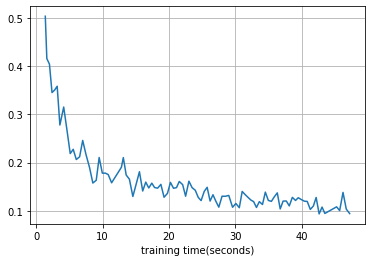

In [324]:
# <YOUR CODE HERE> - actually train the model, track performance, and clean up at the end

Hello, I'm `______` and here's what i've done:

* something